## 22i-2068

In [57]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
######################################################################################
stock_data = yf.download('AAPL') # you can choose whatever stockticker you want

num_days_pred=15 # Number of days you want to predict in the future the higher the less accuracy
######################################################################################

# Here I choose to only use the last 3 years of stock data
slice = int(len(stock_data)- 356*3)
stock_data = stock_data.iloc[slice:]

# Here I Choose to continue with only Close value column since that is what we care about
stock_data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)


# Function to calculate mean absolute error percentage
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def add_lags(df,num_days_pred=num_days_pred):
    target = 'Close'
    df['lag1'] = df[target].shift(num_days_pred)
    df['lag2'] = df[target].shift(num_days_pred*2)
    df['lag3'] = df[target].shift(num_days_pred*3)
    df['lag4'] = df[target].shift(num_days_pred*4)
    df['lag5'] = df[target].shift(num_days_pred*5)
    df['lag6'] = df[target].shift(num_days_pred*6)
    df['lag7'] = df[target].shift(num_days_pred*7)
    df['lag8'] = df[target].shift(num_days_pred*8)
    df['lag9'] = df[target].shift(num_days_pred*9)
    df['lag10'] = df[target].shift(num_days_pred*10)
    df['lag11'] = df[target].shift(num_days_pred*11)
    df['lag12'] = df[target].shift(num_days_pred*12)



    return df

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

[*********************100%%**********************]  1 of 1 completed


In [58]:
df_xgb = stock_data.copy()

In [59]:
def xgboostmodel(df_xgb,add_lags,create_features,num_days_pred=num_days_pred):

    df_xgb = create_features(df_xgb)
    df_xgb = add_lags(df_xgb)

    X = df_xgb.drop(columns='Close')
    y = df_xgb['Close']
    return X,y
X,y = xgboostmodel(df_xgb ,add_lags,create_features,num_days_pred=30)

# Prophet

In [60]:
df_prophet = stock_data.copy()

Split

In [61]:
split_date = df_prophet.index[int(len(df_prophet) * 0.8)]
train = df_prophet.loc[df_prophet.index <= split_date].copy()
test = df_prophet.loc[df_prophet.index > split_date].copy()

Preprocess

In [62]:
# Format data for prophet model using ds and y
train_prophet = train.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})

In [63]:
train_prophet

,ds,y
0,2020-02-18,79.750000
1,2020-02-19,80.904999
2,2020-02-20,80.074997
3,2020-02-21,78.262497
4,2020-02-24,74.544998
...,...,...
850,2023-07-05,191.330002
851,2023-07-06,191.809998
852,2023-07-07,190.679993
853,2023-07-10,188.610001


Training

In [64]:
prophet = Prophet()
prophet.fit(train_prophet)

23:42:59 - cmdstanpy - INFO - Chain [1] start processing
23:42:59 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
# Format data for prophet model using ds and y
test_prophet = test.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})
test_predict = prophet.predict(test_prophet)

Evaluating

In [66]:
porphet_loss = mean_absolute_percentage_error(test['Close'],test_predict['yhat'] )
print(f"ERROR PERCENT = { mean_absolute_percentage_error(test['Close'],test_predict['yhat'] ) }% ")

ERROR PERCENT = 23.244481925318283% 


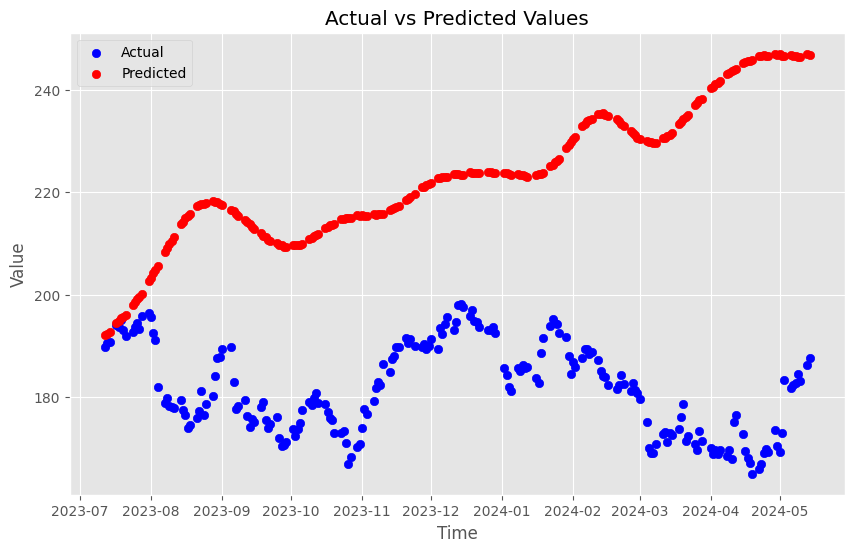

In [67]:
plt.figure(figsize=(10, 6))
plt.scatter(test.index, test['Close'], color='blue', label='Actual')
plt.scatter(test.index, test_predict['yhat'] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

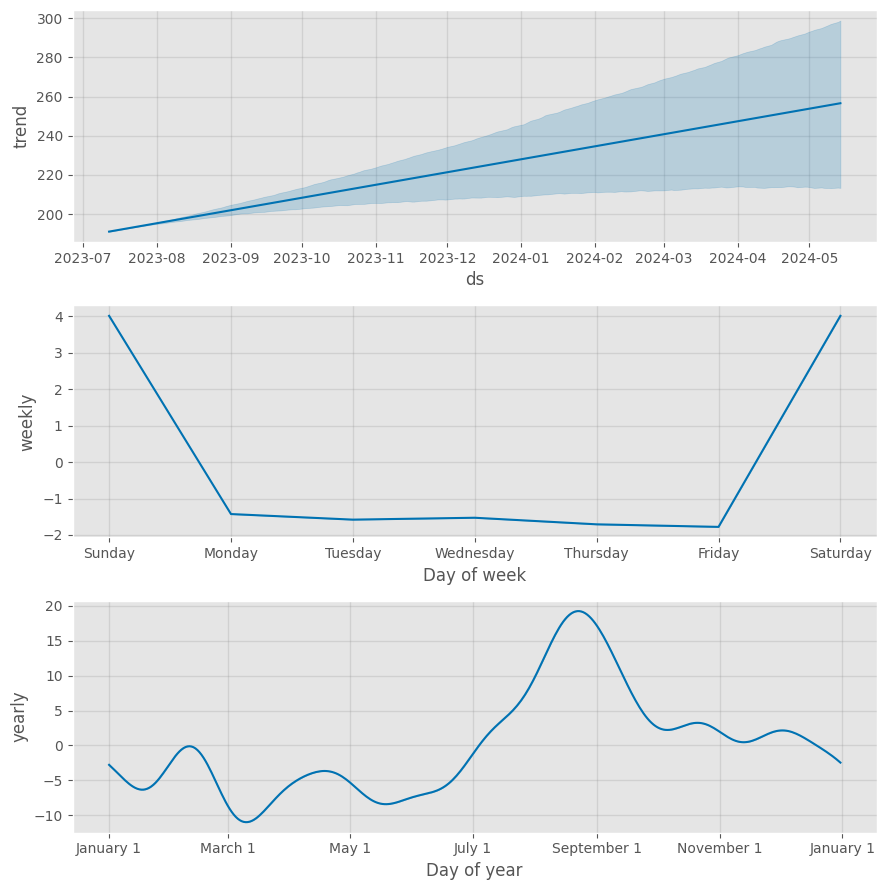

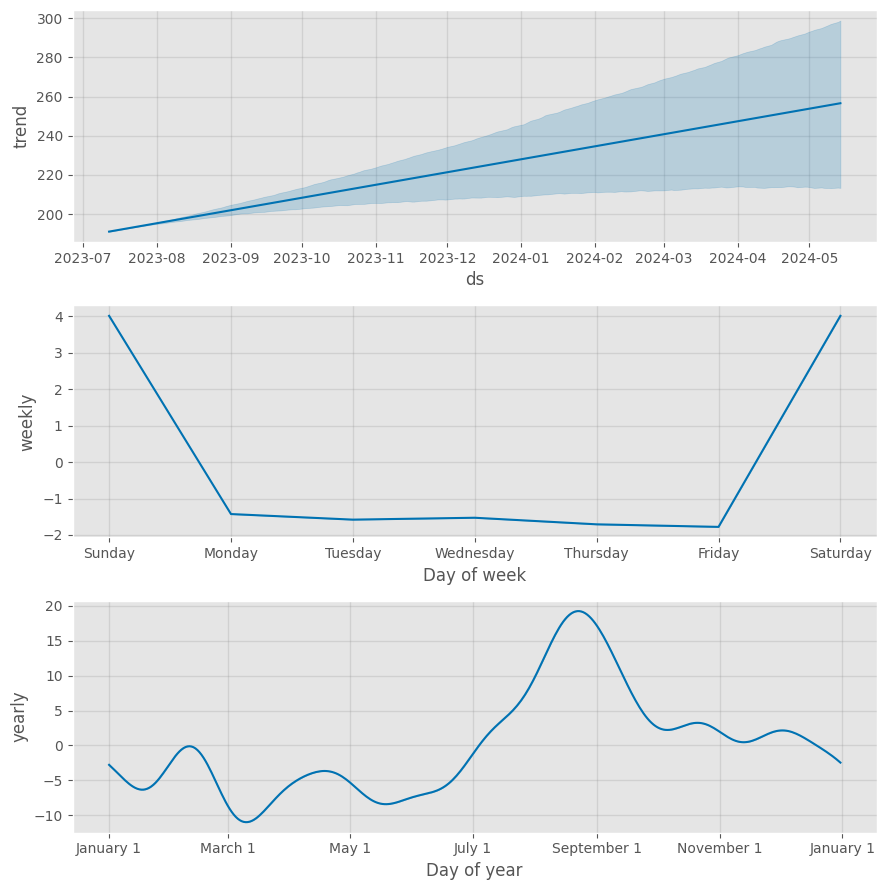

In [68]:
prophet.plot_components(test_predict)

Predicting in the Future

In [69]:
prophet_data = df_prophet.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})
prophet = Prophet()
prophet.fit(prophet_data)

23:43:00 - cmdstanpy - INFO - Chain [1] start processing
23:43:01 - cmdstanpy - INFO - Chain [1] done processing


In [70]:
future = prophet.make_future_dataframe(periods=num_days_pred, freq='d', include_history=False)
forecast = prophet.predict(future)
forecast_prophet = forecast[['ds','yhat']]
forecast_prophet.index = forecast_prophet.pop('ds')

In [71]:
forecast_prophet

,yhat
ds,
2024-05-15,171.227554
2024-05-16,170.812081
2024-05-17,170.552552
2024-05-18,178.940082
2024-05-19,178.674993
2024-05-20,170.047191
2024-05-21,169.687337
2024-05-22,169.413542
2024-05-23,169.061231


# ARIMA

In [72]:
df_arima = stock_data.copy()

Split

In [73]:
split_date = df_prophet.index[int(len(df_arima) * 0.8)]
train_arima = df_arima.loc[df_arima.index <= split_date].copy()
test_arima = df_arima.loc[df_arima.index > split_date].copy()

hyperparamter tuning

In [74]:
# Try to find the best parameters for arima model
stepwise_fit = auto_arima(train_arima['Close'],trace=True,suppress_warnings=True)
# assign the parameter to "best_order" variable
best_order = stepwise_fit.get_params()['order']

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4147.889, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4147.719, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4146.922, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4146.738, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4147.550, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4147.696, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4147.925, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4149.663, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4146.816, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.909 seconds


train

In [75]:
arima = ARIMA(train_arima['Close'], order=best_order)
arima = arima.fit()

evaluate

In [76]:
start = len(train_arima)
end = len(test_arima) + len(train_arima)

In [77]:
pred_arima = arima.predict(start=start,end=end-1)

In [78]:
pred_arima

855     188.118123
856     188.118123
857     188.118123
858     188.118123
859     188.118123
           ...    
1063    188.118123
1064    188.118123
1065    188.118123
1066    188.118123
1067    188.118123
Name: predicted_mean, Length: 213, dtype: float64

In [79]:
pred_arima.index = test_arima.index

<Axes: xlabel='Date'>

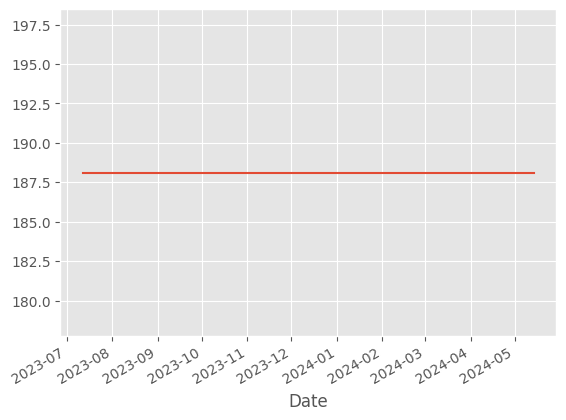

In [80]:
pred_arima.plot()

In [81]:
arima_loss = mean_absolute_percentage_error(test_arima['Close'],pred_arima )
print(f"ERROR PERCENT = { mean_absolute_percentage_error(test_arima['Close'],pred_arima ) }% ")

ERROR PERCENT = 5.163722874914782% 


predict into future

In [82]:
# Try to find the best parameters for arima model
stepwise_fit = auto_arima(df_arima['Close'],trace=True,suppress_warnings=True)
# assign the parameter to "best_order" variable
best_order = stepwise_fit.get_params()['order']

arima = ARIMA(df_arima['Close'], order=best_order)
arima = arima.fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5135.265, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5128.871, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5129.974, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5129.935, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5128.396, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5131.317, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.493 seconds


In [83]:
start = len(df_arima)
end = len(df_arima) + num_days_pred
arima_forecast = arima.predict(start=start,end=end)

In [84]:
start = df_arima.index.max()
end = start + pd.Timedelta(days=num_days_pred)
arima_forecast.index = pd.date_range(start, end, freq='1d')

In [85]:
arima_forecast = pd.DataFrame(arima_forecast)

# Communicate the results

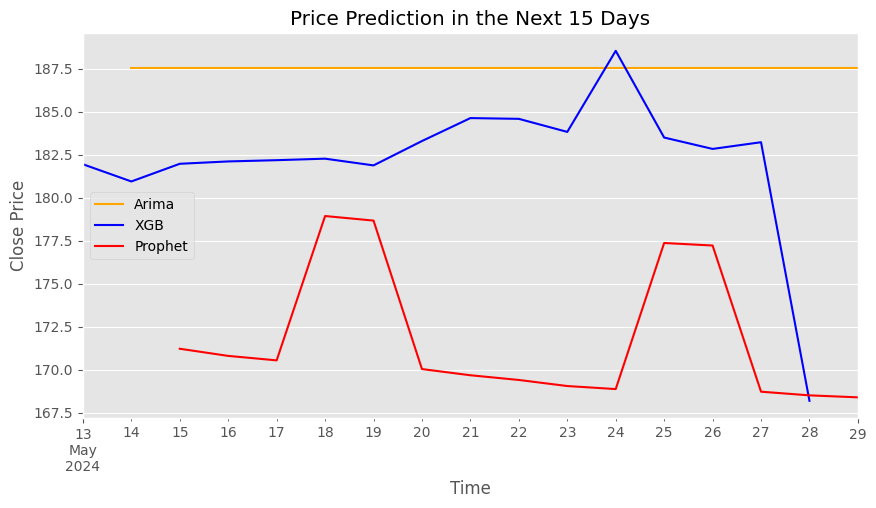

In [86]:
fig, ax  = plt.subplots(figsize=(10,5))
arima_forecast.plot(color='orange',ax=ax)
prediction_xgb.plot(color = 'blue',ax=ax)
forecast_prophet.plot(color = 'red',ax=ax)
plt.legend(['Arima','XGB','Prophet'])
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(f"Price Prediction in the Next {num_days_pred} Days");

In [87]:
print(f"XGB Acc : {100-xgb_loss} \nArima Acc : {100-arima_loss}\nProphet Acc : {100- porphet_loss}")

XGB Acc : 98.24619852781971 
Arima Acc : 94.83627712508522
Prophet Acc : 76.75551807468172


In [88]:
# Check again for missing or infinite values
print("Missing values in X after handling:")
print(X.isnull().sum())
print("Missing values in y after handling:")
print(y.isnull().sum())
print("Infinite values in X after handling:")
print(np.isfinite(X).all().all())
print("Infinite values in y after handling:")
print(np.isfinite(y).all().all())

Missing values in X after handling:
hour            0
dayofweek       0
quarter         0
month           0
year            0
dayofyear       0
dayofmonth      0
weekofyear      0
lag1           15
lag2           30
lag3           45
lag4           60
lag5           75
lag6           90
lag7          105
lag8          120
lag9          135
lag10         150
lag11         165
lag12         180
dtype: int64
Missing values in y after handling:
0
Infinite values in X after handling:
False
Infinite values in y after handling:
True


**ANN**

In [89]:
df_xgb.dropna(inplace=True)

In [90]:
df_xgb = df_xgb.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")

In [91]:
np.isfinite(df_xgb).all().all()

True

In [92]:
print("Missing values in X after handling:")
print(df_xgb.isnull().sum())
print("all finite values in y after handling:")
print(np.isfinite(df_xgb).all().all())

Missing values in X after handling:
Close    0
dtype: int64
all finite values in y after handling:
True


In [93]:
# Assuming df_xgb, add_lags, and create_features are defined elsewhere in your code
X, y = xgboostmodel(df_xgb, add_lags, create_features, num_days_pred=30)


In [94]:
# Check for missing values
print("Missing values in X before handling:")
print(X.isnull().sum())
print("Missing values in y before handling:")
print(y.isnull().sum())

Missing values in X before handling:
hour            0
dayofweek       0
quarter         0
month           0
year            0
dayofyear       0
dayofmonth      0
weekofyear      0
lag1           15
lag2           30
lag3           45
lag4           60
lag5           75
lag6           90
lag7          105
lag8          120
lag9          135
lag10         150
lag11         165
lag12         180
dtype: int64
Missing values in y before handling:
0


In [95]:
X = X.fillna(0)

In [96]:
# After handling missing and infinite values, check again
print("Missing values in X after handling:")
print(X.isnull().sum())
print("Missing values in y after handling:")
print(y.isnull().sum())
print("Infinite values in X after handling:")
print(np.isfinite(X).all().all())
print("Infinite values in y after handling:")
print(np.isfinite(y).all().all())

Missing values in X after handling:
hour          0
dayofweek     0
quarter       0
month         0
year          0
dayofyear     0
dayofmonth    0
weekofyear    0
lag1          0
lag2          0
lag3          0
lag4          0
lag5          0
lag6          0
lag7          0
lag8          0
lag9          0
lag10         0
lag11         0
lag12         0
dtype: int64
Missing values in y after handling:
0
Infinite values in X after handling:
True
Infinite values in y after handling:
True


In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,393 (44.50 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 22208.8730 - val_loss: 22126.8926
Epoch 2/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21539.5645 - val_loss: 21888.6934
Epoch 3/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21934.8105 - val_loss: 21685.0938
Epoch 4/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21007.5000 - val_loss: 21495.7910
Epoch 5/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21413.7383 - val_loss: 21237.4668
Epoch 6/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20812.7930 - val_loss: 20881.2734
Epoch 7/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20009.4688 - val_loss: 20515.8027
Epoch 8/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20946.6816 - val_loss: 20108.9590
Epoch 9/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19593.7520 - val_loss: 19616.1094
Epoch 10/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19723.1504 - val_loss: 19293.0059
Epoch 11/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19324.007

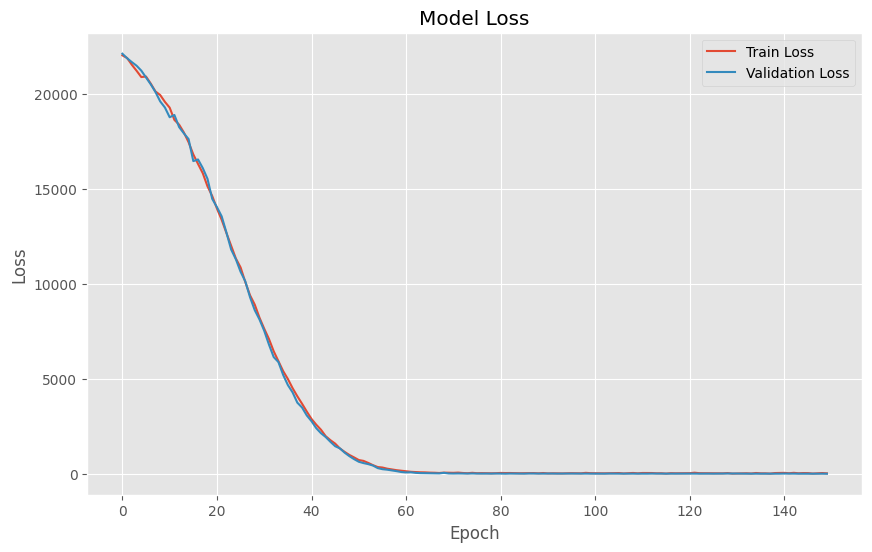

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 14.8204
Test Loss: 15.008828163146973
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


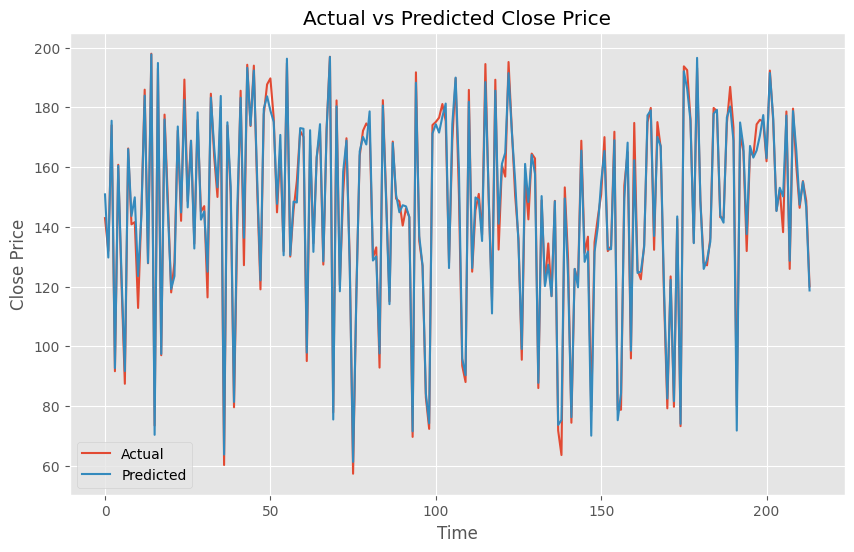

In [98]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
import matplotlib.pyplot as plt


# Get input shape
input_shape = X_train.shape[1]

# Build the model
model = Sequential()
model.add(Dense(128, input_dim=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))  # Output layer for regression

# Compile the model with a smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2)

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
y_pred = model.predict(X_test)

# Compare predictions with actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()


